In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
tf.set_random_seed(777)

In [3]:
def data_standardization(x):
    x_np = np.asarray(x)
    return (x_np - x_np.mean()) / x_np.std()

In [4]:
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7)

In [5]:
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [6]:
input_data_column_cnt = 6  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 1 # 결과데이터의 컬럼 개수
 
seq_length = 28            # 1개 시퀀스의 길이(시계열데이터 입력 개수)
rnn_cell_hidden_dim = 20   # 각 셀의 (hidden)출력 크기
forget_bias = 1.0          # 망각편향(기본값 1.0)
num_stacked_layers = 1     # stacked LSTM layers 개수
keep_prob = 1.0            # dropout할 때 keep할 비율
 
epoch_num = 1000           # 에폭 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.01       # 학습률

In [18]:
stock_file_name = 'excel\lg.csv' # 아마존 주가데이터 파일
encoding = 'euc-kr' # 문자 인코딩
names = ['Date','Open','High','Low','Close','Adj Close','Volume']
raw_dataframe = pd.read_csv(stock_file_name, names=names, encoding=encoding) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력
 
# raw_dataframe.drop('Date', axis=1, inplace=True) # 시간열을 제거하고 dataframe 재생성하지 않기
del raw_dataframe['Date'] # 위 줄과 같은 효과
 
    
stock_info = raw_dataframe.values[1:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다
print("stock_info.shape: ", stock_info.shape)
print("stock_info[0]: ", stock_info[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4173 entries, 0 to 4172
Data columns (total 7 columns):
Date         4173 non-null object
Open         4173 non-null object
High         4173 non-null object
Low          4173 non-null object
Close        4173 non-null object
Adj Close    4173 non-null object
Volume       4173 non-null object
dtypes: object(7)
memory usage: 228.3+ KB
stock_info.shape:  (4172, 6)
stock_info[0]:  [   58380.30078    59655.80078    53278.10156    55927.30078    46864.35547
  4748665.     ]


In [19]:
# 데이터 전처리
# 가격과 거래량 수치의 차이가 많아나서 각각 별도로 정규화한다
 
# 가격형태 데이터들을 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 'Adj Close'까지 취함
# 곧, 마지막 열 Volume를 제외한 모든 열
price = stock_info[:,:-1]
norm_price = min_max_scaling(price) # 가격형태 데이터 정규화 처리
print("price.shape: ", price.shape)
print("price[0]: ", price[0])
print("norm_price[0]: ", norm_price[3000])
print("="*100) # 화면상 구분용
 
a = [[10],[9],[8],[6],[2],[0]]
test_price=min_max_scaling(a)
print("********************************test정규화:",test_price[0])
print("********************************test정규화:",test_price[1])
print("********************************test정규화:",test_price[2])
print("********************************test정규화:",test_price[3])
print("********************************test정규화:",test_price[4])
print("********************************test정규화:",test_price[5])

# 거래량형태 데이터를 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 마지막 'Volume'만 취함
# [:,-1]이 아닌 [:,-1:]이므로 주의하자! 스칼라가아닌 벡터값 산출해야만 쉽게 병합 가능
volume = stock_info[:,-1:]
norm_volume = min_max_scaling(volume) # 거래량형태 데이터 정규화 처리
print("volume.shape: ", volume.shape)
print("volume[0]: ", volume[0])
print("norm_volume[0]: ", norm_volume[0])
print("="*100) # 화면상 구분용
 
# 행은 그대로 두고 열을 우측에 붙여 합친다
x = np.concatenate((norm_price, norm_volume), axis=1) # axis=1, 세로로 합친다
print("x.shape: ", x.shape)
print("x[0]: ", x[0])    # x의 첫 값
print("x[-1]: ", x[-1])  # x의 마지막 값
print("="*100) # 화면상 구분용
 
y = x[:, [-2]] # 타켓은 주식 종가이다
print("y[0]: ",y[0])     # y의 첫 값
print("y[-1]: ",y[-1])   # y의 마지막 값
 
 
dataX = [] # 입력으로 사용될 Sequence Data
dataY = [] # 출력(타켓)으로 사용
 
for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] # 다음 나타날 주가(정답)
    if i is 0:
        print(_x, "->", _y) # 첫번째 행만 출력해 봄
    dataX.append(_x) # dataX 리스트에 추가
    dataY.append(_y) # dataY 리스트에 추가

price.shape:  (4172, 5)
price[0]:  [ 58380.30078  59655.80078  53278.10156  55927.30078  46864.35547]
norm_price[0]:  [ 0.32868455  0.33367108  0.32797219  0.33082164  0.31166512]
********************************test정규화: [ 0.99999999]
********************************test정규화: [ 0.89999999]
********************************test정규화: [ 0.79999999]
********************************test정규화: [ 0.59999999]
********************************test정규화: [ 0.2]
********************************test정규화: [ 0.]
volume.shape:  (4172, 1)
volume[0]:  [ 4748665.]
norm_volume[0]:  [ 0.33476309]
x.shape:  (4172, 6)
x[0]:  [ 0.24163609  0.25072226  0.20528998  0.22416186  0.1596009   0.33476309]
x[-1]:  [ 0.31016315  0.31372496  0.30161481  0.3073137   0.3073137   0.0581838 ]
y[0]:  [ 0.1596009]
y[-1]:  [ 0.3073137]
[[ 0.24163609  0.25072226  0.20528998  0.22416186  0.1596009   0.33476309]
 [ 0.21018318  0.21996819  0.18781644  0.19201011  0.13265933  0.28119299]
 [ 0.18781644  0.21717217  0.17733189  0.20878481  

In [20]:

 
# 학습용/테스트용 데이터 생성
# 전체 70%를 학습용 데이터로 사용
train_size = int(len(dataY) * 0.7)
# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(dataY) - train_size
 
# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
 
# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])
 
 
# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다
X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X: ", X)
Y = tf.placeholder(tf.float32, [None, 1])
print("Y: ", Y)
 
# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.placeholder(tf.float32, [None, 1])
print("targets: ", targets)
 
predictions = tf.placeholder(tf.float32, [None, 1])
print("predictions: ", predictions)


X:  Tensor("Placeholder:0", shape=(?, 28, 6), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
targets:  Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


In [21]:

# 모델(LSTM 네트워크) 생성
def lstm_cell():
    # LSTM셀을 생성
    # num_units: 각 Cell 출력 크기
    # forget_bias:  to the biases of the forget gate 
    #              (default: 1)  in order to reduce the scale of forgetting in the beginning of the training.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell
 
# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()
 
# RNN Cell(여기서는 LSTM셀임)들을 연결
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)
 
# [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# 과거 여러 거래일의 주가를 이용해서 다음날의 주가 1개를 예측하기때문에 MANY-TO-ONE형태이다
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)
 

hypothesis:  Tensor("rnn/transpose:0", shape=(?, 28, 20), dtype=float32)


In [22]:

# 손실함수로 평균제곱오차를 사용한다
loss = tf.reduce_sum(tf.square(hypothesis - Y))
# 최적화함수로 AdamOptimizer를 사용한다
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.RMSPropOptimizer(learning_rate) # LSTM과 궁합 별로임
 
train = optimizer.minimize(loss)
 
# RMSE(Root Mean Square Error)
# 제곱오차의 평균을 구하고 다시 제곱근을 구하면 평균 오차가 나온다
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions))) # 아래 코드와 같다
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))
 
 
train_error_summary = [] # 학습용 데이터의 오류를 중간 중간 기록한다
test_error_summary = []  # 테스트용 데이터의 오류를 중간 중간 기록한다
test_predict = ''        # 테스트용데이터로 예측한 결과
 
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [23]:

# 학습한다
start_time = datetime.datetime.now() # 시작시간을 기록한다
print('학습을 시작합니다...')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)
 
        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))
        
end_time = datetime.datetime.now() # 종료시간을 기록한다
elapsed_time = end_time - start_time # 경과시간을 구한다
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)
 
 
# 하이퍼파라미터 출력
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')
 
print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')
 
print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')
 
print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_test_error:', np.min(test_error_summary))

학습을 시작합니다...
epoch: 100, train_error(A): 0.021195150911808014, test_error(B): 0.022614551708102226, B-A: 0.0014194007962942123
epoch: 200, train_error(A): 0.019932111725211143, test_error(B): 0.02294357679784298, B-A: 0.003011465072631836
epoch: 300, train_error(A): 0.018678663298487663, test_error(B): 0.021906308829784393, B-A: 0.00322764553129673
epoch: 400, train_error(A): 0.017346365377306938, test_error(B): 0.01945054531097412, B-A: 0.002104179933667183
epoch: 500, train_error(A): 0.024367501959204674, test_error(B): 0.015299188904464245, B-A: -0.009068313054740429
epoch: 600, train_error(A): 0.017302418127655983, test_error(B): 0.021246058866381645, B-A: 0.003943640738725662
epoch: 700, train_error(A): 0.016432859003543854, test_error(B): 0.01980201154947281, B-A: 0.003369152545928955
epoch: 800, train_error(A): 0.015659628435969353, test_error(B): 0.017817804589867592, B-A: 0.002158176153898239
epoch: 900, train_error(A): 0.014938635751605034, test_error(B): 0.015118526294827461

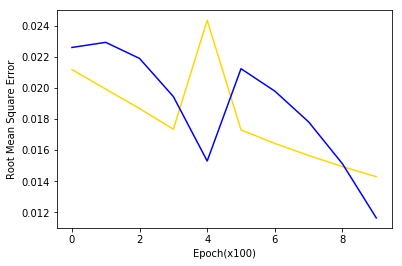

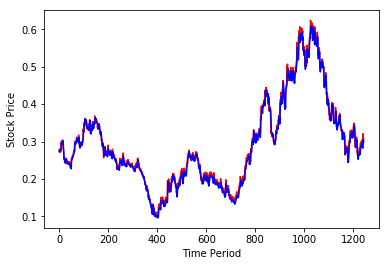

In [24]:

# 결과 그래프 출력
plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')
 
plt.figure(2)
plt.plot(testY, 'r')
plt.plot(test_predict, 'b')
plt.xlabel('Time Period')
plt.ylabel('Stock Price')
plt.show()

In [25]:

 
# sequence length만큼의 가장 최근 데이터를 슬라이싱한다
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)
 
# 내일 종가를 예측해본다
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})
 
print("test_predict", test_predict[0])
test_predict = reverse_min_max_scaling(price,test_predict) # 금액데이터 역정규화한다
print("Tomorrow's stock price", test_predict[0]) # 예측한 주가를 출력한다

recent_data.shape: (1, 28, 6)
recent_data: [[[ 0.30232717  0.30660134  0.28950466  0.29092938  0.28523803  0.06243261]
  [ 0.28523049  0.28523049  0.26599672  0.27169561  0.26623959  0.11777414]
  [ 0.26742144  0.2738327   0.26599672  0.27027089  0.26483229  0.05850012]
  [ 0.26742144  0.27027089  0.26172255  0.26599672  0.26061043  0.03618911]
  [ 0.26029783  0.26670908  0.25744838  0.26243491  0.2570922   0.03193741]
  [ 0.27098325  0.27668215  0.26528436  0.26670908  0.26670908  0.03967868]
  [ 0.26955853  0.27810687  0.2681338   0.26955853  0.26955853  0.03276292]
  [ 0.27668215  0.2830934   0.27240797  0.27312034  0.27312034  0.04010137]
  [ 0.27525742  0.28238104  0.2681338   0.2738327   0.2738327   0.04261929]
  [ 0.27454506  0.27739451  0.26101019  0.26884617  0.26884617  0.04244579]
  [ 0.27525742  0.28665521  0.27240797  0.2830934   0.2830934   0.04653972]
  [ 0.27953159  0.27953159  0.26172255  0.26670908  0.26670908  0.09436812]
  [ 0.26528436  0.27953159  0.264572    0.275

In [26]:
#LG 2019-01-31
#실제값 68100 68400 66200 66600 66600
#예상값 66729 